## Introduction

This jupyter notebook is part of a scientific data visualization pipeline for biomedical images. It displays different types of microscope images—like stained tissue samples and cell masks—so that researchers can explore them interactively. The goal is to combine and visualize multiple types of microscope images from the same tissue sample in a single interactive viewer. This helps scientists study the structure and function of tissues more effectively.

## What Do the Images Represent?

### 1. **H&E Image (Hematoxylin and Eosin)**
- A standard stain in pathology.
- Shows general tissue structure:
  - **Nuclei** appear blue/purple.
  - **Cytoplasm and extracellular matrix** appear pink.
- Useful for identifying tissue architecture and abnormalities.

### 2. **Immunofluorescence (IF) Image**
- Uses fluorescent markers to highlight specific proteins or molecules.
- Reveals **molecular and functional details** of cells.
- Commonly used to study immune responses, cancer markers, and more.

### 3. **Cell Mask (Bitmask Image)**
- A binary image that outlines individual cells.
- Used for **cell segmentation**—identifying and analyzing each cell.
- Enables quantification of cell shapes and sizes and spatial relationships between cells

---

## Image Alignment with Transformation Matrices

Each image comes from a different imaging technique and may be slightly misaligned. To correct this, we use **pre-computed transformation matrices**. These matrices rotate, scale, shear, and move the images so they **line up perfectly**. This alignment is essential for accurate comparison across modalities.

---

## Why Use Vitessce?

Vitessce allows researchers to:

- **Explore complex tissue samples** interactively.
- **Compare multiple imaging modalities** side by side.
- **Zoom and pan** to inspect fine details.
- **Toggle image layers** to focus on specific biological features.
- **Change channel selection and colors** via controls.
- **Adjust opacity of the image layers** to switch bewteen imaging modalities.

This is especially useful in fields like cancer research, neuroscience, and immunology, where understanding the spatial context of cells is crucial.

---

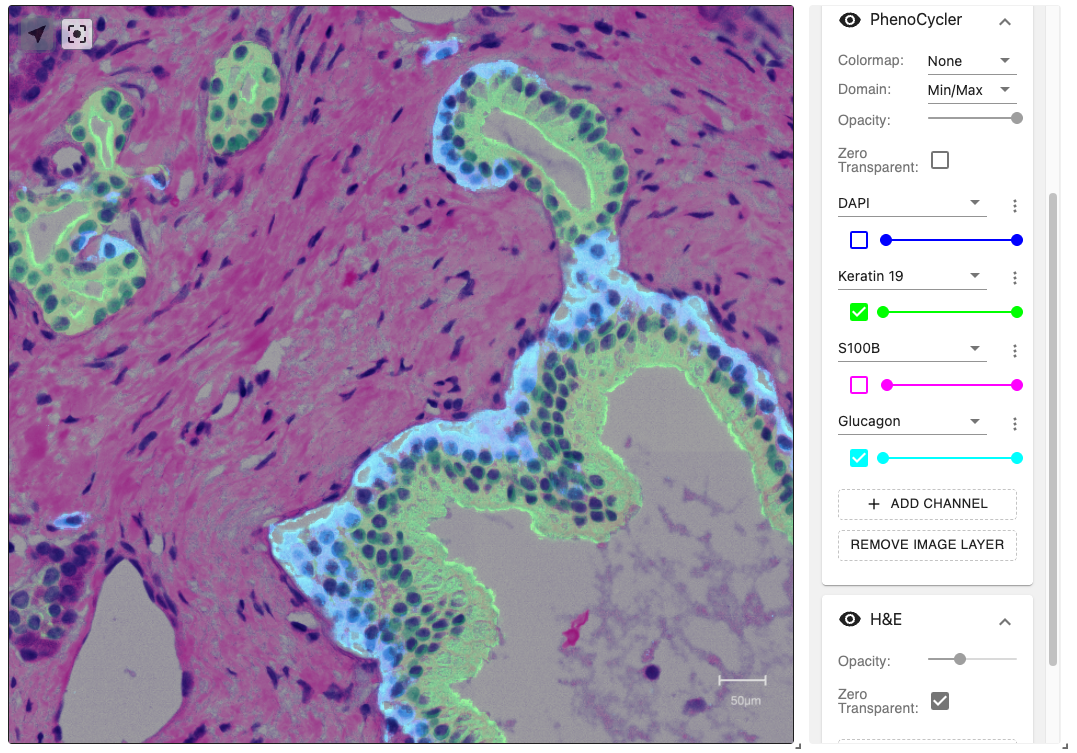

# Code

To get started, download the dataset (~400 MB) from the provided Zenodo repository, then extract (unpack) 
the contents to a local directory on your machine. After unpacking, locate the variable named dataPath 
in the cell below and update its value to point to the folder where you extracted the data. Once you've 
set the correct path, you can run the subsequent cells to visualize 
and explore the multimodal imaging data.

In [ ]:
!curl -L "https://zenodo.org/api/records/15757766/files-archive" -o dataset.zip && unzip dataset.zip && rm dataset.zip

In [ ]:
dataPath = '.'

In [ ]:
import numpy as np
from vitessce import VitessceConfig, Component as cm, OmeTiffWrapper, MultiImageWrapper, hconcat

def loadTransformationMatrix(matPath):
    """
    Loads a 2D transformation matrix from a CSV file and returns it as a flattened 4x4 matrix.

    The input CSV file is expected to contain at least a 2x3 matrix (2 rows, 3 columns),
    where the first two columns represent a 2x2 transformation matrix and the third column
    represents the translation vector.

    Parameters:
        matPath (str): Path to the CSV file containing the transformation matrix.

    Returns:
        list: A flattened list of the 4x4 transformation matrix in column-major order.
    """
    m = np.zeros((4, 4), dtype=np.float32)
    temp = np.loadtxt(matPath, delimiter=',')
    m[:2, :2] = temp[:2, :2]
    m[:2, -1] = temp[:2, -1]
    m[-1, -1] = m[-2, -2] = 1.0
    return m.T.flatten().tolist()

def showDemoImages(dataPath, split=[6, 2], height=800):
    
    """
    Displays a Vitessce visualization of multimodal imaging data from a specified directory.

    This function loads transformation matrices and image data (PhenoCycler IF, H&E, and cell mask)
    from the given `dataPath`, wraps them using `OmeTiffWrapper`, and configures a Vitessce
    visualization layout with spatial and layer controller views.

    Expected files in `dataPath`:
        - 'if-cutout.ome.tif': PhenoCycler immunofluorescence image
        - 'he-cutout.ome.tif': H&E stained image
        - 'mask-cutout.ome.tif': Cell segmentation mask (bitmask)
        - 'if-matrix.csv': Transformation matrix for IF image
        - 'he-matrix.csv': Transformation matrix for H&E image

    Parameters:
        dataPath (str): Path to the directory containing the image and transformation matrix files.
        split (list of int, optional): Layout split ratio for spatial and layer controller views. Default is [6, 2].
        height (int, optional): Height of the embedded Vitessce visualization. Default is 800.

    Returns:
        IPython.display.HTML: An interactive Vitessce visualization embedded in a Jupyter notebook or web interface.
    """
    
    xeCellMaskPath = f'{dataPath}/mask-cutout.ome.tif'
    hePath = f'{dataPath}/he-cutout.ome.tif'
    omemIFPath = f'{dataPath}/if-cutout.ome.tif'
    IFmatPath = f'{dataPath}/if-matrix.csv'
    HEmatPath = f'{dataPath}/he-matrix.csv'
    
    HEmat = loadTransformationMatrix(HEmatPath)
    IFmat = loadTransformationMatrix(IFmatPath)
    
    wrappers = []
    wrappers.append(OmeTiffWrapper(img_path=omemIFPath, name='PhenoCycler', transformation_matrix=IFmat))
    wrappers.append(OmeTiffWrapper(img_path=hePath, name='H&E', transformation_matrix=HEmat))
    wrappers.append(OmeTiffWrapper(img_path=xeCellMaskPath, name='Cells', is_bitmask=True, transformation_matrix=None))
    
    vc = VitessceConfig(schema_version='1.0.17', name='Cutout demo')
    
    dataset = vc.add_dataset(name='Multimodal imaging')
    dataset.add_object(
        MultiImageWrapper(
            image_wrappers=wrappers,
            use_physical_size_scaling=False,))
    
    spatial = vc.add_view(cm.SPATIAL, dataset=dataset)
    lc = vc.add_view(cm.LAYER_CONTROLLER, dataset=dataset).set_props(
        disableChannelsIfRgbDetected=True, visible=True)
    
    vc.layout(hconcat(spatial, lc, split=split))
    return vc.display(height=height)


In [ ]:
showDemoImages(dataPath)

## Bonus: display the entire H&E slide directly from the SenNet storage

Find the region of interest from the example above within the whole slide.

In [ ]:
path = 'https://assets.api.sennetconsortium.org/2ef4830ed058d742cc14d6c4d73370ac/ometiff-pyramids/lab_processed/images/Image_0016903_01.ome.tif?token='
(vc2 := VitessceConfig('1.0.17')).layout(vc2.add_view(cm.SPATIAL, dataset=vc2.add_dataset().add_object(OmeTiffWrapper(img_url=path)))).display(height=1000)